In [2]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

#image
from skimage.transform import resize
from skimage.util import crop
import random
import numpy as np

#keras
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, Add, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, ReLU, LeakyReLU, Conv2DTranspose, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#pip install -q -U tensorboard

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [99]:
#Hyperparameters
BUFFER_SIZE = 400
BATCH_SIZE = 8
IMG_HEIGHT = 480
IMG_WIDTH = 640

EPOCHS =100

In [100]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=4)

    input_image = tf.cast(image, tf.float32)
    input_image = input_image[:, :, :3]
    input_image = input_image / 255.
    
    return input_image

(480, 640, 3)


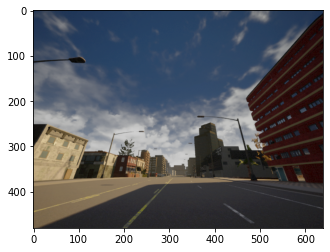

In [101]:
#test_load_image
inp= load('./outputs00/025950.png')
# casting to int for matplotlib to show the image
print(inp.shape)
plt.figure()
plt.imshow(inp)

In [102]:
def load_csv_train(image, label):
    input_image = load(image)

    return input_image, label

def load_csv_test(image, label):
    input_image = load(image)

    return input_image, label

#Input Pipeline
import pandas as pd
import numpy

import os.path
from os import path as PATH

train = []
test = []
for i in range(10):
    num_lines = []
    data = []
    path = './data0%d.csv' %i
    num_lines = sum(1 for l in open(path))
    data = pd.read_csv(path, skiprows=lambda x: ((x>0) and not x % 4)
                       or (x > num_lines - 100), index_col=None, header = 0)
    img_path = data.pop('frame')
    throt = data.pop('throttle')
    steer = data.pop('steer')
    brake = data.pop('brake')
    print(len(data))
    
    k = 0
    for j in range(len(img_path)):
        if PATH.exists('./outputs00/0%s.png' %img_path[j]) and k<400:
            label = [throt[j], steer[j], brake[j]]
            
            if(np.random.randint(10)==1):
                test.append(['./outputs00/0%s.png' %img_path[j], label])
            else:
                train.append(['./outputs00/0%s.png' %img_path[j], label])

            k = k + 1
    print(len(test))
    print(len(train))


from sklearn.utils import shuffle
train = shuffle(train)
test = shuffle(test)
image_train = []
label_train = []
image_test = []
label_test = []
for image, label in train:
    image_train.append(image)
    label_train.append(label)

for image, label in test:
    image_test.append(image)
    label_test.append(label)

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, label_train))
train_dataset = train_dataset.map(load_csv_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((image_test, label_test))
test_dataset = test_dataset.map(load_csv_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

1187
47
353
1354
79
721
1577
116
1084
1389
149
1451
1455
184
1816
1384
222
2178
1620
264
2536
1580
308
2892
1467
347
3253
1576
374
3626


In [103]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
def create_model():
    base_model = Xception(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    predictions = Dense(3, activation="linear")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=["accuracy"])
    return model

In [51]:
model = create_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 239, 319, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 239, 319, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 239, 319, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [52]:
checkpoint_path = "./Xception_Train_Models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch',
    period = 10)

model.save_weights(checkpoint_path.format(epoch=0))

history = model.fit(train_dataset, epochs=EPOCHS, 
                    validation_data=(test_dataset),
                    callbacks=[cp_callback])

Epoch 1/100
889/889 [==============================] - 441s 496ms/step - loss: 0.0363 - accuracy: 0.9116 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
 45/889 [>.............................] - ETA: 7:04 - loss: 0.0258 - accuracy: 0.9489

KeyboardInterrupt: 

In [ ]:
latest = "./DenseNet_Train_Models/cp-0100.ckpt"
print(latest)

In [104]:
from tensorflow.keras.layers import AveragePooling2D
def model_base_64x3_CNN():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH,3), padding='same'))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='same'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='same'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='same'))

    model.add(Flatten())
    model.add(Dense(2048))
    model.add(Dense(3, activation="linear"))

    return model.input, model.output

In [105]:
inp, out = model_base_64x3_CNN()
model_2 = Model(inputs=inp, outputs=out)
model_2.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48_input (InputLayer) [(None, 480, 640, 3)]     0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 480, 640, 64)      1792      
_________________________________________________________________
activation_28 (Activation)   (None, 480, 640, 64)      0         
_________________________________________________________________
average_pooling2d_27 (Averag (None, 160, 214, 64)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 160, 214, 64)      36928     
_________________________________________________________________
activation_29 (Activation)   (None, 160, 214, 64)      0         
_________________________________________________________________
average_pooling2d_28 (Averag (None, 54, 72, 64)        0  

In [106]:
checkpoint_path = "./CNN_Train_Models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch',
    period = 10)

model_2.save_weights(checkpoint_path.format(epoch=0))

optimizer = Adam(lr=0.001)
model_2.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(),
            metrics=['accuracy'])
history = model_2.fit(train_dataset, epochs=250, 
                    validation_data=(test_dataset),
                    callbacks=[cp_callback])

Epoch 1/250
454/454 [==============================] - 59s 129ms/step - loss: 0.8795 - accuracy: 0.9076 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/250
454/454 [==============================] - 56s 123ms/step - loss: 0.0166 - accuracy: 0.9413 - val_loss: 0.0172 - val_accuracy: 0.8904
Epoch 3/250
454/454 [==============================] - 56s 123ms/step - loss: 0.0130 - accuracy: 0.9451 - val_loss: 0.0103 - val_accuracy: 0.9733
Epoch 4/250
454/454 [==============================] - 57s 126ms/step - loss: 0.0110 - accuracy: 0.9567 - val_loss: 0.0104 - val_accuracy: 0.9786
Epoch 5/250
454/454 [==============================] - 58s 128ms/step - loss: 0.0093 - accuracy: 0.9619 - val_loss: 0.0134 - val_accuracy: 0.9866
Epoch 6/250
454/454 [==============================] - 57s 126ms/step - loss: 0.0088 - accuracy: 0.9658 - val_loss: 0.0068 - val_accuracy: 0.9786
Epoch 7/250
454/454 [==============================] - 58s 128ms/step - loss: 0.0080 - accuracy: 0.9658 - val_loss: 

Epoch 51/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0032 - accuracy: 0.9873 - val_loss: 0.0030 - val_accuracy: 0.9947
Epoch 52/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0031 - accuracy: 0.9862 - val_loss: 0.0034 - val_accuracy: 0.9947
Epoch 53/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0033 - accuracy: 0.9854 - val_loss: 0.0026 - val_accuracy: 0.9920
Epoch 54/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0028 - accuracy: 0.9879 - val_loss: 0.0032 - val_accuracy: 0.9947
Epoch 55/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0028 - accuracy: 0.9870 - val_loss: 0.0027 - val_accuracy: 0.9920
Epoch 56/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0029 - accuracy: 0.9892 - val_loss: 0.0026 - val_accuracy: 0.9947
Epoch 57/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0029 - accuracy: 0.9851 - val_loss: 0

454/454 [==============================] - 57s 126ms/step - loss: 0.0018 - accuracy: 0.9912 - val_loss: 0.0032 - val_accuracy: 0.9947
Epoch 102/250
454/454 [==============================] - 57s 126ms/step - loss: 0.0018 - accuracy: 0.9906 - val_loss: 0.0025 - val_accuracy: 0.9920
Epoch 103/250
454/454 [==============================] - 57s 127ms/step - loss: 0.0016 - accuracy: 0.9939 - val_loss: 0.0030 - val_accuracy: 0.9920
Epoch 104/250
454/454 [==============================] - 57s 126ms/step - loss: 0.0017 - accuracy: 0.9923 - val_loss: 0.0030 - val_accuracy: 0.9947
Epoch 105/250
454/454 [==============================] - 57s 127ms/step - loss: 0.0016 - accuracy: 0.9909 - val_loss: 0.0028 - val_accuracy: 0.9893
Epoch 106/250
454/454 [==============================] - 57s 127ms/step - loss: 0.0016 - accuracy: 0.9939 - val_loss: 0.0035 - val_accuracy: 0.9920
Epoch 107/250
454/454 [==============================] - 57s 127ms/step - loss: 0.0017 - accuracy: 0.9903 - val_loss: 0.0029 -

Epoch 151/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0011 - accuracy: 0.9934 - val_loss: 0.0026 - val_accuracy: 0.9947
Epoch 152/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0011 - accuracy: 0.9931 - val_loss: 0.0021 - val_accuracy: 0.9947
Epoch 153/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0012 - accuracy: 0.9926 - val_loss: 0.0027 - val_accuracy: 0.9947
Epoch 154/250
454/454 [==============================] - 57s 127ms/step - loss: 0.0011 - accuracy: 0.9939 - val_loss: 0.0025 - val_accuracy: 0.9920
Epoch 155/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0011 - accuracy: 0.9926 - val_loss: 0.0027 - val_accuracy: 0.9947
Epoch 156/250
454/454 [==============================] - 58s 127ms/step - loss: 0.0011 - accuracy: 0.9923 - val_loss: 0.0026 - val_accuracy: 0.9947
Epoch 157/250
454/454 [==============================] - 57s 127ms/step - loss: 0.0011 - accuracy: 0.9926 - val_

Epoch 201/250
454/454 [==============================] - 58s 127ms/step - loss: 8.6611e-04 - accuracy: 0.9934 - val_loss: 0.0026 - val_accuracy: 0.9920
Epoch 202/250
454/454 [==============================] - 58s 127ms/step - loss: 8.1032e-04 - accuracy: 0.9945 - val_loss: 0.0030 - val_accuracy: 0.9920
Epoch 203/250
454/454 [==============================] - 58s 127ms/step - loss: 8.5551e-04 - accuracy: 0.9956 - val_loss: 0.0026 - val_accuracy: 0.9893
Epoch 204/250
454/454 [==============================] - 57s 126ms/step - loss: 8.0627e-04 - accuracy: 0.9953 - val_loss: 0.0025 - val_accuracy: 0.9893
Epoch 205/250
454/454 [==============================] - 57s 127ms/step - loss: 8.8859e-04 - accuracy: 0.9945 - val_loss: 0.0022 - val_accuracy: 0.9893
Epoch 206/250
454/454 [==============================] - 58s 127ms/step - loss: 8.7603e-04 - accuracy: 0.9926 - val_loss: 0.0025 - val_accuracy: 0.9893
Epoch 207/250
454/454 [==============================] - 58s 127ms/step - loss: 7.9583e-

454/454 [==============================] - 60s 132ms/step - loss: 7.4126e-04 - accuracy: 0.9923 - val_loss: 0.0026 - val_accuracy: 0.9893


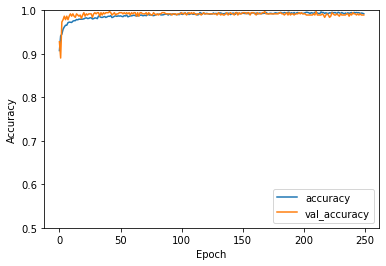

In [107]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
latest = "./DenseNet_Train_Models/cp-0100.ckpt"
print(latest)